This notebook is mainly for figuring out how to manipulate the mock catalogues in the ways we want, with the goal of transitioning to scripts / package functions later on

In [96]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import pandas as pd
# plt.style.use('dark_background')
from scipy.interpolate import InterpolatedUnivariateSpline
from astropy import units as u
from astropy.coordinates import SkyCoord
import glob, time, dask

from nbodykit.lab import *
import nbodykit.cosmology as cosmology
from nbodykit.source.catalog import ArrayCatalog
from nbodykit.transform import SkyToCartesian, StackColumns, CartesianToSky
from nbodykit.algorithms import FKPCatalog
from nbodykit.binned_statistic import BinnedStatistic
from nbodykit.algorithms.convpower.fkp import ConvolvedFFTPower
from nbodykit.algorithms.convpower.catalogmesh import FKPCatalogMesh
from nbodykit.algorithms.zhist import RedshiftHistogram

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
from mock_utils.load_supermock import *
from mock_utils.sample_analysis_utils import *

In [3]:
# load in catalog files
# WARNING: Memory intensive!
test_data, test_items = load_all_available_catalogs(dirIn = 'Downsampled_SuperMocks/') # Read all the available files

Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_0_every_1000.hdf5
Total number of original galaxies: 7169
Total number of cleaned galaxies: 4257
Total number of removed galaxies: 2912
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_1_every_1000.hdf5
Total number of original galaxies: 7062
Total number of cleaned galaxies: 3966
Total number of removed galaxies: 3096
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_2_every_1000.hdf5
Total number of original galaxies: 7005
Total number of cleaned galaxies: 3943
Total number of removed galaxies: 3062
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Total number of original galaxies: 7128
Total number of cleaned galaxies: 4253
Total number of removed galaxies: 2875
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_Sup

In [4]:
# extract the info we want and remove the rest
ra_full = np.array(test_data['ra_true'])
dec_full = np.array(test_data['dec_true'])
redshift = np.array(test_data['redshift_true'])

del test_data

In [74]:
# Redshift cuts
min_z = 0.2
max_z = 0.4

ra_cut = ra_full[(redshift > min_z) & (redshift < max_z)]
dec_cut = dec_full[(redshift > min_z) & (redshift < max_z)]
redshift_cut = redshift[(redshift > min_z) & (redshift < max_z)]

print("cut catalog has {:0.0f} galaxies".format(len(redshift_cut)))

# initialize cosmology (needed for redshift -> catresian transformation
# the fiducial BOSS DR12 cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.30964)#, Omega0_b=0.04897)
cosmo = cosmo.match(sigma8=0.8102)

cut catalog has 41975 galaxies


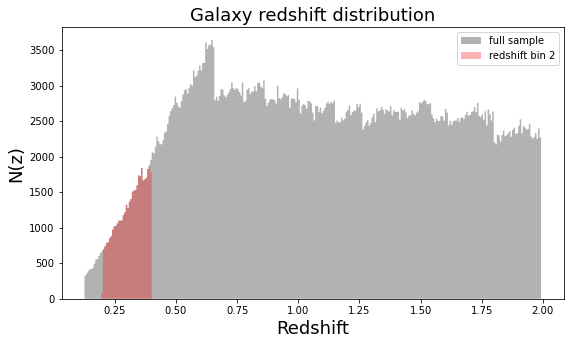

In [124]:
# plot the redshift distribution
plt.figure(figsize=(9, 5))
nbins = np.linspace(np.amin(redshift), np.amax(redshift), 300)
nbins_cut = nbins[(nbins < 0.55)]
plt.hist( redshift, bins = nbins, label='full sample', alpha=0.3, color='k', histtype='stepfilled', lw=2);
plt.hist( redshift_cut, bins = nbins, label='redshift bin 2', alpha=0.3, color='r', histtype='stepfilled', lw=2);

plt.title('Galaxy redshift distribution', fontsize=18)
plt.xlabel('Redshift', fontsize=18)
plt.ylabel('N(z)', fontsize=18)
# plt.xlim(0, 0.52)
plt.legend()

In [76]:
def get_survey_volume(min_z, max_z, cosmo):
    # x, y, z = radec_to_cartesian(0., 0., [min_z, max_z])
    # print(x, y, z)
    # min_d = np.sqrt(x[0]*x[0] + y[0]*y[0] + z[0]*z[0])
    # #x, y, z = radec_to_cartesian(0., 0., max_z)
    # max_d = np.sqrt(x[1]*x[1] + y[1]*y[1] + z[1]*z[1])
    # return abs(4./3. * np.pi * (max_d**3 - min_d**3))

    dummy_dict = np.empty(1, dtype=[("ra", "f4"), ("dec", "f4"), ("min_z", "f4"), ("max_z", "f4")])
    dummy_dict["ra"] = 0.; dummy_dict["dec"] = 0.; dummy_dict["min_z"] = min_z; dummy_dict["max_z"] = max_z
    dummy_cat = ArrayCatalog(dummy_dict)
    
    min_d = quad(integrand, 0, min_z)[0]
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["min_z"],degrees=True, cosmo=cosmo)).compute()
    min_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)

    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["max_z"],degrees=True, cosmo=cosmo)).compute()
    max_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)
    print(min_d, max_d)
    return abs(4./3. * np.pi * (max_d**3 - min_d**3))

def get_dVolume_dz(z_bins, cosmo):
    dummy_dict = np.empty(len(z_bins), dtype=[("ra", "f4"), ("dec", "f4"), ("z", "f4")])
    dummy_dict["ra"] = np.zeros(len(z_bins)); dummy_dict["dec"] = np.zeros(len(z_bins)); dummy_dict["z"] = z_bins
    dummy_cat = ArrayCatalog(dummy_dict)
    
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["z"],degrees=True, cosmo=cosmo)).compute()
    d = np.sqrt(position[:,0]**2 + position[:,1]**2 + position[:,2]**2)
    dV = np.zeros(len(d)-1)
    
    for i in range(len(dV)):
        dV[i] = 4./3. * np.pi * (d[i+1]**3 - d[i]**3)
    return dV

49 49


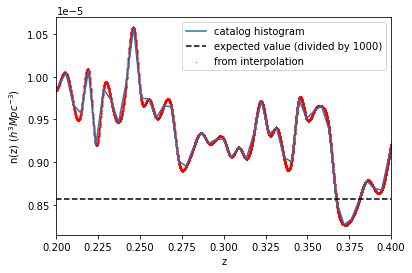

In [112]:
# create a nbar vector with a n(z) value for every redshift
# do this by using interpolation from the above plot
#V = get_survey_volume(np.amin(redshift_cut), 0.55, cosmo)

nbar, z_edges = np.histogram(redshift, bins=np.linspace(min_z-0.01, max_z+0.01, 50))
dV_dz = get_dVolume_dz(z_edges, cosmo)

print(len(nbar), len(dV_dz))
nbar = nbar / dV_dz
z_centers = np.zeros(len(nbar))
for i in range(len(z_centers)):
    z_centers[i] = (z_edges[i] + z_edges[i+1]) / 2.
    
nbar_func = InterpolatedUnivariateSpline(z_centers, nbar)
nbar_cut = nbar_func(redshift_cut)

plt.figure()
plt.scatter(redshift_cut, nbar_cut, s=0.1, c="red", label="from interpolation")
plt.plot(z_centers, nbar, label="catalog histogram")
plt.axhline(0.00857 / 1000, c="black", ls="--", label="expected value (divided by 1000)")
plt.xlim(min_z, max_z)
plt.xlabel("z")
plt.ylabel(r"n(z) $(h^{3} Mpc^{-3})$")
plt.legend()

In [113]:
# visualize the cut sample's distribution on the full sky
# TODO: Try converting this to a healpix map
# fig = plt.figure(figsize=(10, 5))

# ##########################
# ax = fig.add_subplot(111)

# # Only plotting random 10,000 galaxies
# n_gal = 10000
# random_gal_indices = np.random.randint(low=0, high=ra_cut.shape[0], size=n_gal)

# ra_octant = ra_cut[random_gal_indices]
# dec_octant = dec_cut[random_gal_indices]

# # Define the orthographic projection centered on the equator and prime meridian
# m = Basemap(projection='moll', lat_0=-60, lon_0=90, resolution='c')
# # Convert RA, Dec to x, y coordinates for plotting
# x, y = m(ra_octant, dec_octant)

# # Plot the sky distribution
# m.scatter(x, y, s=2, c='white', alpha=0.5, edgecolors='w', linewidth=1)

# # Draw parallels and meridians
# # m.drawparallels(np.arange(-90.,90.,22.5), color='yellow', textcolor='yellow', linewidth=2)
# # m.drawmeridians(np.arange(0.,360.,22.5), color='yellow', textcolor='yellow', linewidth=2)
# m.drawmapboundary(fill_color='black')
# # m.drawcoastlines(color='black', linewidth=0.5)
 
# plt.suptitle('Sky Distribution of Galaxies with z < 0.5', fontsize=20)
# plt.show()

## Use nbodykit to generate the power spectrum of this map

In [114]:
wtype=np.dtype([('ra',ra_cut.dtype),('dec',dec_cut.dtype),('z',redshift_cut.dtype), ("nbar", nbar_cut.dtype)])
data=np.empty(len(ra_cut),dtype=[('ra',ra_cut.dtype),('dec',dec_cut.dtype),('z',redshift_cut.dtype), ("nbar", nbar_cut.dtype)])
data['ra']=ra_cut
data['dec']=dec_cut
data['z']=redshift_cut
data["nbar"]=nbar_cut

data = ArrayCatalog(data)

In [115]:
def create_survey_randoms(num_galaxies, z_min, z_max, cosmo):
    
    dummy_dict = np.empty(1, dtype=[("ra", "f4"), ("dec", "f4"), ("min_z", "f4"), ("max_z", "f4")])
    dummy_dict["ra"] = 0.; dummy_dict["dec"] = 0.; dummy_dict["min_z"] = z_min; dummy_dict["max_z"] = z_max
    dummy_cat = ArrayCatalog(dummy_dict)
    
    min_d = quad(integrand, 0, min_z)[0]
    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["min_z"],degrees=True, cosmo=cosmo)).compute()
    min_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)

    position = (SkyToCartesian(dummy_cat["ra"], dummy_cat["dec"], dummy_cat["max_z"],degrees=True, cosmo=cosmo)).compute()
    max_d = np.sqrt(position[0,0]**2 + position[0,1]**2 + position[0,2]**2)
    print(min_d, max_d)
    i = 0
    random = np.zeros((num_galaxies, 3))
    while i < num_galaxies:
        random_pos = np.vstack((
            np.random.uniform(-1*max_d, max_d, 1),
            np.random.uniform(-1*max_d, max_d, 1),
            np.random.uniform(-1*max_d, max_d, 1)
        )).T
        d = np.linalg.norm(random_pos)
        if d > min_d and d < max_d:
            random[i,:] = random_pos
            i = i+1
    
    random_dict=np.empty(len(random),dtype=[('X',random.dtype),('Y',random.dtype),('Z',random.dtype)])
    random_dict['X']=random[:,0]
    random_dict['Y']=random[:,1]
    random_dict['Z']=random[:,2]

    random = ArrayCatalog(random_dict)
    random["Position"] = StackColumns((random["X"], random["Y"], random["Z"]))
    return random

In [116]:
# transform coordinates
data['Position'] = SkyToCartesian(data['ra'], data['dec'], data['z'], degrees=True, cosmo=cosmo)

#random = create_box_randoms(len(data["ra"]), data)
random = create_survey_randoms(len(ra_cut)*10, min_z, max_z, cosmo)
random["ra"], random["dec"], random["z"] = CartesianToSky(random["Position"], cosmo)

random["nbar"] = nbar_func(random["z"])

#x, y, z = radec_to_cartesian(ra_cut, dec_cut, redshift_cut)
#print(np.amax(x) - np.amin(x), np.amax(redshift_cut))

570.8853227158975 1083.0868346334407


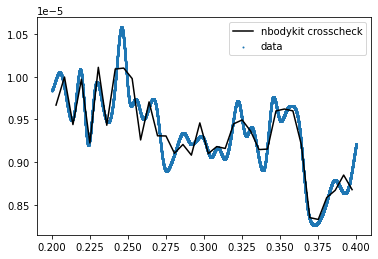

In [117]:
# plt.scatter(random["X"], random["Y"], s=0.01)

rhist = RedshiftHistogram(data, 1., cosmo, redshift="z")

plt.figure()
plt.scatter(data["z"], data["nbar"], s=1, label="data")
plt.plot(rhist.bin_centers, rhist.nbar, c="black", label="nbodykit crosscheck")
#plt.scatter(random["z"], random["nbar"], s=1, label="random")
plt.legend()

In [120]:
# we're dealing with a box right now, so we don't need to generate a random catalog (I think)

Catalog_Survey = FKPCatalog(data, random, nbar="nbar")

t1 = time.time()
mesh = Catalog_Survey.to_mesh(Nmesh=128, nbar='nbar')
result_survey = ConvolvedFFTPower(mesh, poles=[0,2], kmin=0.0, kmax=0.13)

print("Power spectrum took {:0.2f} s to compute".format(time.time() - t1))
#r = FFTPower(data, mode="1d", Nmesh=128, BoxSize=3400)
#r = FFTPower(cat, mode='2d', Nmesh=32, Nmu=5, poles=[0,2,4])

/home/joeadamo/anaconda3/envs/spherex-lkl/lib/python3.6/site-packages/nbodykit/algorithms/convpower/fkp.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  xgrid = [xx.astype('f8') + offset[ii] for ii, xx in enumerate(density2.slabs.optx)]
/home/joeadamo/anaconda3/envs/spherex-lkl/lib/python3.6/site-packages/nbodykit/algorithms/convpower/fkp.py:536: ComplexWarning: Casting complex values to real discards the imaginary part
  kgrid = [kk.astype('f8') for kk in cfield.slabs.optx]


Power spectrum took 2.29 s to compute


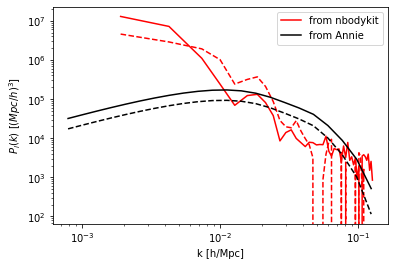

In [126]:
prediction = np.loadtxt("redshift_bin_2_Joe.txt")
k_pred = prediction[:,0]
P0_pred = prediction[:,1]
P2_pred = prediction[:,2]

poles = result_survey.poles
plt.plot(poles["k"], poles["power_0"].real - poles.attrs['shotnoise'], color="red", label="from nbodykit")
plt.plot(poles["k"], poles["power_2"].real, color="red", ls="--")

plt.plot(k_pred, P0_pred, color="black", label="from Annie")
plt.plot(k_pred, P2_pred, color="black", ls="--")
#plt.plot(poles["k"], poles["power_4"], label="l = 4")
plt.xlabel(r"k [h/Mpc]")
plt.ylabel(r"$P_l(k)$ $[(Mpc/h)^3]$")
#plt.xscale("log")
plt.yscale("log")
plt.xscale("log")
plt.legend()

## Code to generate simple noisy mocks from the supermock

In [89]:
sigma_ra = 0.05
sigma_dec = 0.05
# From the website, the 490M galaxy sample will have <10% redshift uncertainty
# Alternatively, the smaller higher percision sample will havve ~0.3% uncertainty
sigma_z = 0.1 * (min_z + max_z)/2.
print(sigma_z)
sigma_z = 0.01
ra_noisy, dec_noisy, redshift_noisy = add_gaussian_noise(ra_cut, dec_cut, redshift_cut, sigma_ra, sigma_dec, sigma_z)

0.030000084638595582


(array([  64.,  174.,  289.,  390.,  472.,  606.,  682.,  697.,  814.,
         903.,  893.,  928., 1013., 1101., 1064., 1118., 1127., 1004.,
        1016., 1134., 1093., 1111., 1164., 1150., 1225., 1143., 1160.,
        1160., 1125., 1158., 1078., 1057., 1024., 1074., 1076., 1058.,
         971.,  966.,  919.,  892.,  876.,  811.,  680.,  613.,  565.,
         462.,  373.,  270.,  177.,   55.]),
 array([-89.66365495, -86.07277609, -82.48189724, -78.89101839,
        -75.30013954, -71.70926068, -68.11838183, -64.52750298,
        -60.93662413, -57.34574527, -53.75486642, -50.16398757,
        -46.57310872, -42.98222986, -39.39135101, -35.80047216,
        -32.20959331, -28.61871445, -25.0278356 , -21.43695675,
        -17.8460779 , -14.25519904, -10.66432019,  -7.07344134,
         -3.48256249,   0.10831637,   3.69919522,   7.29007407,
         10.88095292,  14.47183178,  18.06271063,  21.65358948,
         25.24446833,  28.83534719,  32.42622604,  36.01710489,
         39.60798374,  4

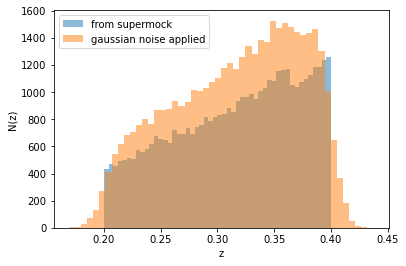

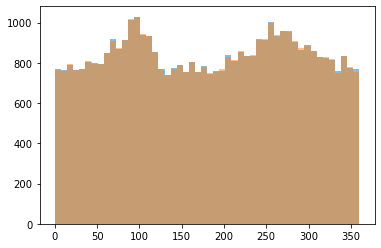

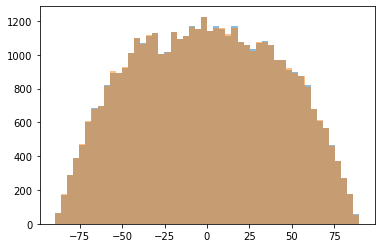

In [91]:
plt.hist(redshift_cut, bins=50, alpha=0.5, label="from supermock")
plt.hist(redshift_noisy, bins=50, alpha=0.5, label="gaussian noise applied")
plt.legend()
plt.xlabel("z")
plt.ylabel("N(z)")

plt.figure()
plt.hist(ra_cut, bins=50, alpha=0.5)
plt.hist(ra_noisy, bins=50, alpha=0.5)

plt.figure()
plt.hist(dec_cut, bins=50, alpha=0.5)
plt.hist(dec_noisy, bins=50, alpha=0.5)